##### Mamy co prawda dodatkowe benefity dla naszych najlepszych klientów, ale może dałoby się ustalić kto potencjalnie jest skłonny wydawać u nas więcej?

#### Kontekst
- sklep internetowy z elektroniką i grami komputerowymi.

#### Zadanie biznesowe
- przewidywanie czy dana sesja klienta zakończy się zakupem po zaoferowaniu mu odpowiedniej zniżki


#### Biznesowe kryterium sukcesu
- system powinien poprawnie przewidywać zakończenie sesji (wyświetlenie / zakup)

#### Definicja zadania/zadań modelowania

- ##### Zadanie modelowania: 
    klasyfikacja

- ##### Dane do modelowania
    Zbiór danych sesji uzupełnionych o ceny, kategorie produktów oraz miasto zamieszkania usera.
    - users: id, city
    - sessions: session_id, user_id, timestamp, product_id, **event_type, offered_discount**, purchase_id
    - product_id, category_path, **price**
    
Finalna decyzja zakupu może mieć duży związek z interakcją ceny z obniżką. Klient może być bardziej skory do kupna, jeżeli dostanie 10% zniżki na produkt o wartości 1000 zł, niż do kupna produktu z tą samą zniżką, ale o wartości 100 zł. 

- ##### Analityczne kryterium sukcesu
Zbudowanie zbalansowanego modelu, który przewyższa skuteczność modelu naiwnego.

_Model naiwny w naszym przypadku mógłby przewidywać tylko VIEW PRODUCT i miałby wtedy około 85,7% skuteczności (Aktualnie na 6 akcji VIEW PRODUCT, mamy 1 akcję BUY PRODUCT (14.3%))._

#### Założenia
- przewidujemy klasę dla danych wejściowych (event type: VIEW PRODUCT lub BUY PRODUCT)
- parametry analitycznego kryterium sukcesu są ustalone bezpośrednio na podstawie biznesowego kryterium sukcesu.

#### Analiza danych z perspektywy realizacji zadań

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import statsmodels.graphics.api as smg

In [2]:
import os, glob

inputs = []

for each in sorted(glob.glob(os.path.join(os.getcwd(),'data/*.jsonl'), recursive=True)):
    print(f'Name with path: {each} \nName without path: {os.path.basename(each)}')
    inputs.append(each)

Name with path: /home/olkuka/Pulpit/Studia/IUM/IUM-project/data/deliveries.jsonl 
Name without path: deliveries.jsonl
Name with path: /home/olkuka/Pulpit/Studia/IUM/IUM-project/data/products.jsonl 
Name without path: products.jsonl
Name with path: /home/olkuka/Pulpit/Studia/IUM/IUM-project/data/sessions.jsonl 
Name without path: sessions.jsonl
Name with path: /home/olkuka/Pulpit/Studia/IUM/IUM-project/data/users.jsonl 
Name without path: users.jsonl


In [3]:
deliveries = pd.read_json(inputs[0], lines=True)
products = pd.read_json(inputs[1], lines=True)
sessions = pd.read_json(inputs[2], lines=True)
users = pd.read_json(inputs[3], lines=True)

In [4]:
# No missing data in users
users.count()

user_id    200
name       200
city       200
street     200
dtype: int64

In [5]:
users.sample(3)

,user_id,name,city,street
50,152,Bianka Tlałka,Konin,aleja Rataja 389
184,286,Mariusz Szramka,Warszawa,pl. Daszyńskiego 34/75
20,122,Mariusz Jany,Warszawa,ul. Krasińskiego 26


In [6]:
# Users names are unique
users.name.nunique()

200

In [7]:
deliveries.count()

purchase_id           5297
purchase_timestamp    5297
delivery_timestamp    5016
delivery_company      5045
dtype: int64

In [8]:
deliveries.sample(3)

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
884,20885,2021-02-22T13:59:01,2021-02-24T13:59:10,516.0
604,20605,2020-12-30T14:40:56,2021-01-02T14:43:08,360.0
3089,23090,2021-02-20T16:50:46,2021-02-25T16:52:28,360.0


In [9]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5297 entries, 0 to 5296
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   purchase_id         5297 non-null   int64  
 1   purchase_timestamp  5297 non-null   object 
 2   delivery_timestamp  5016 non-null   object 
 3   delivery_company    5045 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 165.7+ KB


In [10]:
pd.DataFrame({'total_missing': deliveries.isnull().sum(), 'perc_missing': (deliveries.isnull().sum()/deliveries.purchase_id.count())*100})

,total_missing,perc_missing
purchase_id,0,0.00000
purchase_timestamp,0,0.00000
delivery_timestamp,281,5.30489
delivery_company,252,4.75741


In [11]:
sessions.describe()

,session_id,user_id,product_id,offered_discount,purchase_id
count,37539.000000,35657.000000,35696.000000,37539.000000,5297.000000
mean,105310.580729,199.224388,1128.044851,4.921815,22649.000000
std,3049.208276,57.835868,119.183838,7.074449,1529.256519
min,100001.000000,102.000000,1001.000000,0.000000,20001.000000
25%,102677.000000,150.000000,1035.000000,0.000000,21325.000000
50%,105326.000000,196.000000,1067.000000,0.000000,22649.000000
75%,107956.000000,252.000000,1278.000000,10.000000,23973.000000
max,110597.000000,301.000000,1319.000000,20.000000,25297.000000


In [12]:
sessions.sample(3)

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
6234,101803,2020-12-20 22:41:08,134.0,1233.0,VIEW_PRODUCT,5,NaN
9380,102677,2020-05-23 13:01:45,150.0,1045.0,VIEW_PRODUCT,15,NaN
14815,104192,2021-03-11 23:24:06,176.0,1081.0,VIEW_PRODUCT,0,NaN


In [13]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37539 entries, 0 to 37538
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        37539 non-null  int64         
 1   timestamp         37539 non-null  datetime64[ns]
 2   user_id           35657 non-null  float64       
 3   product_id        35696 non-null  float64       
 4   event_type        37539 non-null  object        
 5   offered_discount  37539 non-null  int64         
 6   purchase_id       5297 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 2.0+ MB


In [14]:
pd.DataFrame({'total_missing': sessions.isnull().sum(), 'perc_missing': (sessions.isnull().sum()/sessions.session_id.count())*100})

,total_missing,perc_missing
session_id,0,0.000000
timestamp,0,0.000000
user_id,1882,5.013453
product_id,1843,4.909561
event_type,0,0.000000
offered_discount,0,0.000000
purchase_id,32242,85.889342


W tabeli sessions widzimy, że niektóre product_id są nan (dokładnie 1843 rekordy). Przez to wiersze z tymi pustymi wartościami są nam zbędne, bo nie ma sposobu, abyśmy doszli do tego jaki był oglądany/kupiony produkt. Nie możemy usunąć tych wierszy, ponieważ nie jesteśmy pewni czy te braki są MCAR - nie wiemy nic o tym, czy zależą od zmiennych ukrytych, czy też nie. 

Widzimy też, że w 1882 rekordach brakuje nam  user_id. Te wiersze prawdopodobnie nic nie wniosą do naszego algorytmu klasyfikacji, ponieważ nie możemy ich połączyć z żadnym z użytkowników z tabeli users. 

Sprawdzamy czy braki w danych są losowe heurystyką pokazaną na wykładzie. Dla zmiennej z brakami danych tworzymy zmienną wskaźnikową, która przyjmuje wartość 1, gdy są braki lub 0, gdy nie ma braków. Następnie za pomocą macierzy korelacji analizujemy zależności między utworzoną zmienną wskaźnikową, a pozostałymi. Najpierw dla user_id (zmienna wskaźnikowa: user_id_test), a następnie dla product_id (product_id_test).

In [15]:
sessions_cp = sessions.copy()
sessions_cp['user_id_test'] = np.where(sessions_cp.user_id.isnull(), 1, 0)
sessions_cp = sessions_cp.drop(["user_id"], axis=1)
# sessions_cp = pd.get_dummies(sessions_cp)

cols = sessions_cp.columns.tolist()
cols.remove("timestamp")

In [16]:
sessions_cp.corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

,session_id,product_id,offered_discount,purchase_id,user_id_test
session_id,1.000,-0.001,-0.007,1.000,-0.004
product_id,-0.001,1.000,-0.018,-0.020,0.010
offered_discount,-0.007,-0.018,1.000,0.000,0.002
purchase_id,1.000,-0.020,0.000,1.000,0.005
user_id_test,-0.004,0.010,0.002,0.005,1.000


Możemy zauważyć, że zmienna wskaźnikowa user_id_test jest słabo skorelowana z innymi atrybutami. Wciąż jednak nie mamy pewności czy braki nie są MNAR. Nie jesteśmy pewni, czy zmienna ta nie jest zależna od innej zmiennej ukrytej (związanej np. z używaną przez klienta przeglądarką i/lub z wersją systemu operacyjnego, na którym była ta przeglądarka uruchomiona).

In [17]:
sessions_cp = sessions.copy()
sessions_cp['product_id_test'] = np.where(sessions_cp.user_id.isnull(), 1, 0)
sessions_cp = sessions_cp.drop(["product_id"], axis=1)
# sessions_cp = pd.get_dummies(sessions_cp)

cols = sessions_cp.columns.tolist()
cols.remove("timestamp")

In [18]:
sessions_cp.corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

,session_id,user_id,offered_discount,purchase_id,product_id_test
session_id,1.000,0.999,-0.007,1.000,-0.004
user_id,0.999,1.000,-0.007,0.999,nan
offered_discount,-0.007,-0.007,1.000,0.000,0.002
purchase_id,1.000,0.999,0.000,1.000,0.005
product_id_test,-0.004,nan,0.002,0.005,1.000


Identyfikator produktu jest także słabo skorelowany z pozostałymi zmiennymi. W tym wypadku także nie możemy wykluczyć opcji, że braki są MNAR.

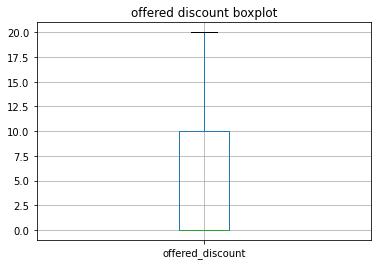

In [19]:
# nie ma żadnych wartości odstających do poprawienia
numerical_columns = ["offered_discount"]
sessions[numerical_columns].boxplot()
plt.title("offered discount boxplot")
plt.show()

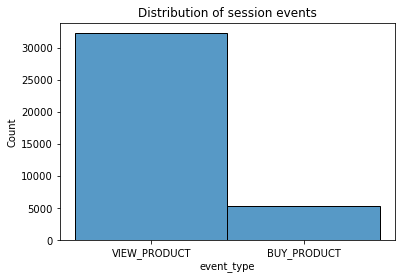

In [20]:
sn.histplot(sessions.event_type)
plt.title("Distribution of session events")
plt.show()

# na 6 oglądań, średnio mamy 1 zakup

In [21]:
# ile brakuje purchase_id gdy typ sesji to BUY_PRODUCT
sessions[sessions.event_type=="BUY_PRODUCT"].purchase_id.isna().sum()

0

Gdy ktoś kupuje produkt, zawsze znamy id tego produktu.

In [22]:
# ile sesji typu VIEW_PRODUCT ma purchase_id (prawdopodobnie niepotrzebne informacje)
sessions[sessions.event_type=="VIEW_PRODUCT"].purchase_id.notna().sum()

0

In [23]:
# Brak pustych komórek.
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


In [24]:
products.sample(3)

,product_id,product_name,category_path,price
124,1125,Diablo 3 (PC),Gry i konsole;Gry komputerowe,69.90
57,1058,Angry Birds Classic (PC),Gry i konsole;Gry komputerowe,24.99
39,1040,Crysis 2 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,79.90


In [25]:
products.describe()

,product_id,price
count,319.000000,3.190000e+02
mean,1160.000000,5.370644e+06
std,92.231593,4.231655e+07
min,1001.000000,-2.450000e+02
25%,1080.500000,2.390000e+01
50%,1160.000000,4.499000e+01
75%,1239.500000,1.109900e+02
max,1319.000000,6.887800e+08


Po prostym poleceniu describe() wykonanym na tabeli products widzimy, że w danych pojawiają się ujemne ceny. Nie jest to możliwe. Dodatkowo widzimy, że istnieją takie ceny (bądź jedna cena), która wyraźnie odstaje od reszty, tym samym nielogicznie zawyża średnią i odchylenie standardowe. Trzeba koniecznie zidentyfikować te wartości i dopytać się klienta, czy są one w ogóle możliwe. 

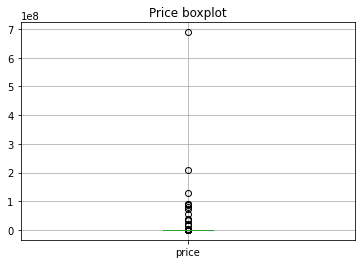

In [26]:
numerical_columns = ['price']
products[numerical_columns].boxplot()
plt.title('Price boxplot')
plt.show()

Widzimy jak bardzo odstają nam wartości w kwotach rzędu milionowego. Na wykresie widać to idealnie, ponieważ 25%, 50% i 75% znajdują się w tym samym miejscu na 0 (zielona linia). To oznacza, że niestety mamy tutaj dużo wartości odstających, z którymi trzeba coś zrobić. Pojawia się jednak pytanie - którą kwotę jako pierwszą można uznać za odstającą?

In [27]:
products[products['price'] > 50000]

,product_id,product_name,category_path,price
27,1028,Sniper Ghost Warrior 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,39000000.0
31,1032,LCD Iiyama E2280WSD,Komputery;Monitory;Monitory LCD,688780000.0
40,1041,Crysis 3 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,79900000.0
48,1049,Max Payne 3 (PC),Gry i konsole;Gry komputerowe,17900000.0
66,1067,Nokia 3310,Telefony i akcesoria;Telefony komórkowe,207330000.0
73,1074,Gembird BTCC-002,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,86280000.0
87,1088,Fallout New Vegas (PC),Gry i konsole;Gry komputerowe,32990000.0
143,1144,Street Fighter 4 (PC),Gry i konsole;Gry komputerowe,1990000.0
213,1214,Call of Cthulhu Mroczne zakamarki Świata (PC),Gry i konsole;Gry komputerowe,18990000.0
222,1223,Call of Duty Black Ops 2 (PC),Gry i konsole;Gry komputerowe,32990000.0


Eksperymentalnie dobraliśmy wartość 50 000 jako granicę. Nie było to trudne, ponieważ w tabeli mamy tylko 319 rekordów, przez co możemy je manualnie przeglądać. Każdą z odstających wartości zastąpimy medianą z danej kategorii. 

In [28]:
# Ceny niedodatnie
products[products['price'] <= 0].count()

product_id       16
product_name     16
category_path    16
price            16
dtype: int64

Jest dokładnie 16 niedodatnich cen. Po przejrzeniu tych 16 wartości widzimy, że mają one sens. Mamy w tym momencie kilka opcji. Możemy oczywiście usunąć produkty z ujemnymi cenami (ale wtedy stracimy ok. 5% danych). Możemy także pomnożyć ujemne ceny przez -1 otrzymując wtedy dodatnie, normalne kwoty. Jest jeszcze opcja, aby zrobić tak jak z poprzednimi dużymi odstającymi wartościami i zastąpić te ujemne ceny medianą z cen w danej kategorii.

In [29]:
products[products['price'] <= 0]

,product_id,product_name,category_path,price
47,1048,Gra o tron (PC),Gry i konsole;Gry komputerowe,-63.49
91,1092,Company of Heroes (PC),Gry i konsole;Gry komputerowe,-34.99
120,1121,Battlefield 3 Powrót do Karkand (PC),Gry i konsole;Gry komputerowe,-29.99
138,1139,F1 2012 (PC),Gry i konsole;Gry komputerowe,-71.99
154,1155,The Sims 3 Kariera (PC),Gry i konsole;Gry komputerowe,-31.90
159,1160,Street Racing Syndicate (PC),Gry i konsole;Gry komputerowe,-11.90
179,1180,Split/Second (PC),Gry i konsole;Gry komputerowe,-24.90
185,1186,Symulator Budowy Mostów (PC),Gry i konsole;Gry komputerowe,-18.24
189,1190,Star Wars The Force Unleashed 2 (PC),Gry i konsole;Gry komputerowe,-70.90
202,1203,LEGO Batman 2 DC Super Heroes (PC),Gry i konsole;Gry komputerowe,-29.99


Po konsultacjach otrzymaliśmy nowy zbiór danych, który po sprawdzeniu okazał się być pozbawionym wszystkich błędów. To właśnie na nim będziemy tworzyć nasze modele. 